# Modelagem do dataset Auto

Com o objetivo de praticar a análise exploratória dos dados e entender melhor os algoritmos supervisionados iremos analisar o dataset __Auto__ respondendo as questões do capítulo 4, exercício 11 do livro _An Introduction to Statistical Learning: with Applications in R._ 

Iremos, portanto, ao longo deste notebook realizar, principalmente, as seguintes atividades:

a) Binarizar a variável target. <br>
b) Análise descritiva dos dados. <br>
c) Dividir dataset em conjunto de treinamento e teste. <br>
d) Modelar o dataset com o algoritmo de análise discriminante linear e verificar seu erro. <br>
e) Modelar o dataset com o algoritmo de análise discriminante quadrático e verificar seu erro. <br>
f) Modelar o dataset com o algoritmo de regressão logística e verificar seu erro. <br>
g) Modelar o dataset com o algoritmo de vizinhos mais próximos e verificar seu erro.

Dataset disponível em: https://archive.ics.uci.edu/ml/datasets/auto+mpg <br>
Livro disponívek em: https://www.ime.unicamp.br/~dias/Intoduction%20to%20Statistical%20Learning.pdf

### Análise exploratória e pré-processamento

In [1]:
#Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Leitura do dataset
cars1 = pd.read_csv('auto-mpg.data',sep=',',header=None,names = ['mpg','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','car_name'], na_values = '?')

#Apresentando algumas linhas do dataset
cars1.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


Segundo a documentação do dataset há Na valores, portanto, iremos identificá-los e tratá-los.

In [3]:
#Identificando atributos com Na valores
for col in cars1.columns:
    print(col,': ',cars1[col].isna().sum(),sep='')

mpg: 0
cylinders: 0
displacement: 0
horsepower: 6
weight: 0
acceleration: 0
model_year: 0
origin: 0
car_name: 0


In [4]:
#Substituir Na valores pela média no atributo horsepower
horsepower_mean = cars1['horsepower'].mean()
cars1['horsepower'] = cars1['horsepower'].map(lambda x: horsepower_mean if pd.isnull(x) else x)

#Fazendo a checagem da substituição
cars1['horsepower'].isna().sum()

0

In [5]:
#Checagem de tipos para verificar se os atributos estão todos corretamente tipados
cars1.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
model_year        int64
origin            int64
car_name         object
dtype: object

Dada a documentação do dataset e pesquisa realizada sobre os atributos, já iremos remover algumas características que aparentam não ser relevantes para o nosso modelo de predição.

In [6]:
#Pré-selecao das variaveis
cars2 = cars1.iloc[:,0:6].copy()
cars2.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration
0,18.0,8,307.0,130.0,3504,12.0
1,15.0,8,350.0,165.0,3693,11.5
2,18.0,8,318.0,150.0,3436,11.0
3,16.0,8,304.0,150.0,3433,12.0
4,17.0,8,302.0,140.0,3449,10.5


Boa parte dos algoritmos de classificação precisam que os dados sejam normalizados para melhor desempenho. Logo, iremos realizar uma normalização no intervalo [0,1].

In [7]:
#Normalizando
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
cars2.iloc[:,:] = min_max_scaler.fit_transform(cars2)

#Mostrando o dataset normalizado
cars2.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration
0,0.239362,1.0,0.617571,0.456522,0.536150,0.238095
1,0.159574,1.0,0.728682,0.646739,0.589736,0.208333
2,0.239362,1.0,0.645995,0.565217,0.516870,0.178571
3,0.186170,1.0,0.609819,0.565217,0.516019,0.238095
4,0.212766,1.0,0.604651,0.510870,0.520556,0.148810


### Binarização

In [8]:
#Binarizando a variável target por meio da mediana
mpg_median = cars2['mpg'].median()

cars2['mpg'] = cars2['mpg'].map(lambda x: 1 if x >= mpg_median else 0)

In [9]:
#Verificando se há desbalanceamento nos dados
cars2.groupby('mpg').size()

mpg
0    197
1    201
dtype: int64

### Análise descritiva

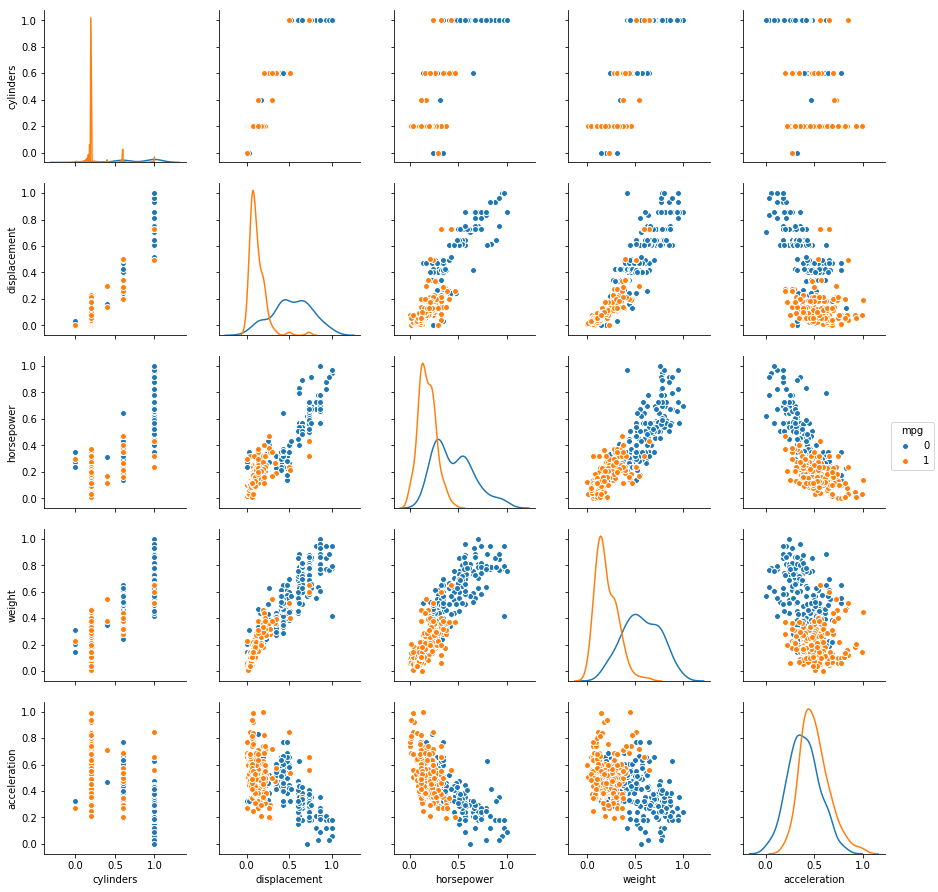

In [10]:
#Verificando a distribuição dos dados assim como suas relações
sns.pairplot(cars2,hue='mpg',diag_kind='kde',vars=['cylinders','displacement','horsepower','weight','acceleration'])
plt.show()

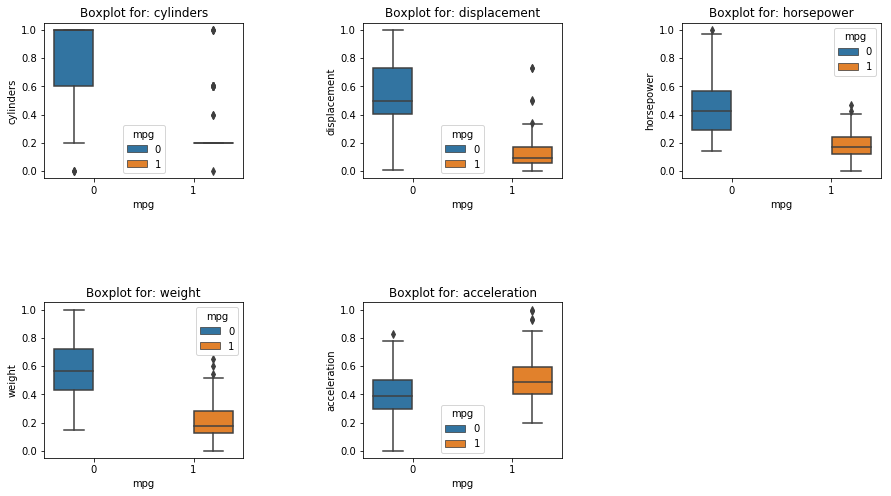

In [11]:
#Boxplot
plt.figure(figsize=(15,8))
plt.subplots_adjust(wspace=0.6,hspace=0.8)
for attribute,index in zip(cars2.columns,range(6)):
    if(attribute != 'mpg'):
        plt.subplot(2,3,index)
        plt.title('Boxplot for: ' + attribute)
        sns.boxplot(data=cars2[[attribute,'mpg']],x='mpg',y=attribute,hue='mpg')
plt.show()

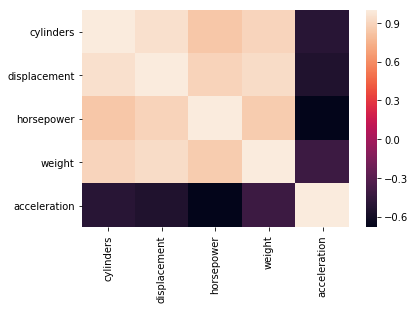

In [12]:
#Matriz de correlação
corr =  cars2.iloc[:,1:6].corr()

#Heatmap
sns.heatmap(corr)
plt.show()

Pelos gráficos de dispersão, boxplot e heatmap verificamos que os atributos __weight__ e __acceleration__ aparentam ser as melhores escolhas. Isso se deve pelos seguintes fatos:

1 - Realizam uma boa separação razoável dos dados. <br> 
2 - São as variáveis menos colineares. <br>
3 - Aparentam seguir uma normal (não há garantias de que é).

Esses três fatores são algumas premissas que ajudam nossos modelos a terem melhores resultados. Além disso, foi realizada a escolha de apenas 2 variáveis, pois acreditamos que com elas já é possível explicar bem o modelo. Provavelmente a adição de mais atributos iria adicionar complexidade desnecessária ao modelo.

In [13]:
#Selecao de variaveis para modelagem
cars3 = cars2.iloc[:,[0,4,5]].copy()
cars3.head()

,mpg,weight,acceleration
0,0,0.536150,0.238095
1,0,0.589736,0.208333
2,0,0.516870,0.178571
3,0,0.516019,0.238095
4,0,0.520556,0.148810


### Divisão do dataset em treino e teste

In [14]:
from sklearn.model_selection import train_test_split

#Split do dataset em treino(75%) e teste(25%)
X_train, X_test, y_train, y_test = train_test_split(cars3.iloc[:,1:3],cars3.iloc[:,0])

### Modelagem

Iremos modelar os algoritmos dos itens _d_ a _g_ e verificar seu erro médio quadrático.

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#Criando modelos
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()
lr = LogisticRegression()
_3nn = KNeighborsClassifier(n_neighbors = 3)
_5nn = KNeighborsClassifier(n_neighbors = 5)
_7nn = KNeighborsClassifier(n_neighbors = 7)
_9nn = KNeighborsClassifier(n_neighbors = 9)

#Lista com os classificadores
clfs = [lda,qda,lr,_3nn,_5nn,_7nn,_9nn]

#Lista com o nome dos classificadores
clfs_names = ['lda','qda','lrn','3nn','5nn','7nn','9nn']

In [16]:
from sklearn.metrics import mean_squared_error

#Calculando erro médio quadrático de cada modelo
for name,c in zip(clfs_names,clfs):
    c.fit(X_train,y_train)
    y_predict = c.predict(X_test)
    print('Squared mean error for ',name,': ',mean_squared_error(y_test,y_predict),sep='')

Squared mean error for lda: 0.13
Squared mean error for qda: 0.11
Squared mean error for lrn: 0.13
Squared mean error for 3nn: 0.15
Squared mean error for 5nn: 0.13
Squared mean error for 7nn: 0.1
Squared mean error for 9nn: 0.12
